# Explaining Diabetes Risk Predictions with SHAP and XGBoost

#### Trustworthy AI Examples Series

This notebook demonstrates how lack of model transparency can obscure critical decision factors in clinical risk prediction. Using the Diabetes dataset, this example scenario simulates a diagnostic pipeline that predicts undiagnosed diabetes based on biometric and demographic features. Model explainability is then performed, targeting feature attribution by applying global and local explanation techniques, ultimately comparing their performance by measuring contribution consistency across patient subgroups to build a more trustworthy prediction system.

Clinicians and healthcare administrators increasingly demand not only high predictive accuracy for risk‑stratification models but also a clear understanding of why the model makes certain calls—both to build trust and to satisfy regulations around explainability in medicine (e.g., FDA’s Software as a Medical Device guidance). High blood pressure or BMI thresholds may drive treatment decisions, so quantifying each factor’s contribution is important.

Through this scenario, readers will:

1. **Understand the real‑world stakes**: how and why opaque predictions in diabetes screening can erode clinical trust.
2. **Learn to construct end-to-end AI pipelines**: from data cleaning to model training to explanation.
3. **Apply fairness strategies in-context**: using TreeSHAP, summary plots, and force plots to balance transparency and clinical relevance.

In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path().resolve().parents[1]
sys.path.insert(0, str(PROJECT_ROOT))

## Imports & Utilities

This notebook will use functions from the `preprocessing.py` file located in the `utils` folder. It is recommended to review the file to gain an understanding of the functions being used before continuing. Click [here](../../python/utils/preprocessing.py) to see the file.

### XGBoost

**XGBoost** is a high-performance library for gradient-boosted decision trees. It is used here for:

- `XGBClassifier`: a classification model based on gradient-boosted trees.

### SHAP

**SHAP** is a unified framework for interpreting predictions of complex models. It assigns each feature an importance value for a particular prediction, based on game theory. It is used here for:

- `TreeExplainer`: an explainer optimized for tree-based models that computes exact SHAP values efficiently.
- `summary_plot`: generates a summary plot of feature importance, showing how features impact model output across the dataset.
- `force_plot`: visualizes individual prediction explanations, illustrating how each feature contributes to the final score.
- `waterfall`: displays a waterfall chart for a single prediction, breaking down the contribution of each feature from the base value to the final prediction.

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, roc_auc_score

from xgboost import XGBClassifier

import shap

import python.utils.preprocessing as pp

## Data Preparation

In order to train a model on the Diabetes dataset, raw data must be converted into a clean, numeric, and standardized format. After loading the dataset from the CSV file, the first step is to handle any missing values to ensure consistency and avoid errors during model training.

In this case, missing values are imputed using the median of each column, which is a robust strategy that avoids data loss while mitigating the influence of outliers.

To prepare the dataset for modeling, first transform categorical variables using one-hot encoding, excluding the target to preserve its interpretability. Next, apply standardization to the numerical features to ensure they are on a comparable scale, which is crucial for many machine learning algorithms.

The `split_data` splits the data for model training and evaluation.

In [16]:
file_path = PROJECT_ROOT / 'data/diabetes_binary_full.csv'
df = pp.load_data(file_path)
df = pp.handle_missing_values(df, strategy='median')

target_col = 'Diabetes_binary'

df_enc = pp.encode_categorical_data(df, method='onehot', exclude_cols=[target_col])
df_scaled = pp.scale_features(df_enc, method='standardize', exclude_cols=[target_col])

X_train, X_test, y_train, y_test = pp.split_data(df_scaled, target_col=target_col, test_size=0.2)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"Number of features: {X_test.shape[1] if X_train.shape[1] == X_test.shape[1] else -1}")

Training set size: 202944 samples
Test set size: 50736 samples
Number of features: 63


## XGBoost Model

### Model Training

The model used in this scenario is an `XGBClassifier` from the XGBoost library, configured with:

- **`n_estimators=200`**: the number of boosting rounds.
- **`max_depth=5`**: limits tree depth to prevent overfitting.
- **`learning_rate=0.1`**: controls the contribution of each tree.
- **`eval_metric='logloss'`**: appropriate for binary classification.

The model is trained on the preprocessed training data using `.fit()`. This step builds an ensemble of decision trees that iteratively improve prediction accuracy by correcting errors from previous rounds.

In [8]:
model = XGBClassifier(n_estimators=200,
                      max_depth=5,
                      learning_rate=0.1,
                      eval_metric='logloss',
                      random_state=42)

model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

### Model Evaluation

After training, the model is evaluated on the test set using accuracy, which measures the proportion of correct predictions, and ROC AUC, an indication of the model’s ability to distinguish between classes.

These results (86.8% accuracy, 0.834 ROC AUC) show strong performance, suggesting the model is well-calibrated and generalizes effectively to unseen data.

In [9]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)
print(f"Accuracy: {acc:.3f}")
print(f"ROC AUC: {auc:.3f}")

Accuracy: 0.868
ROC AUC: 0.834


## SHAP Explainability

### Global Explanation: SHAP Summary Plot

The SHAP summary plot reveals the most influential features across the entire dataset. Red points (positive SHAP values) indicate features pushing the prediction toward diabetes. Blue points (negative SHAP values) indicate features pushing the prediction away from diabetes.

Although some features are segmented via one-hot encoding, we can still see an obvious trend in terms of importance. `BMI`, `HighBP`, and `HighChol` are the top contributors to diabetes predictions, as supported by subsequent plots.


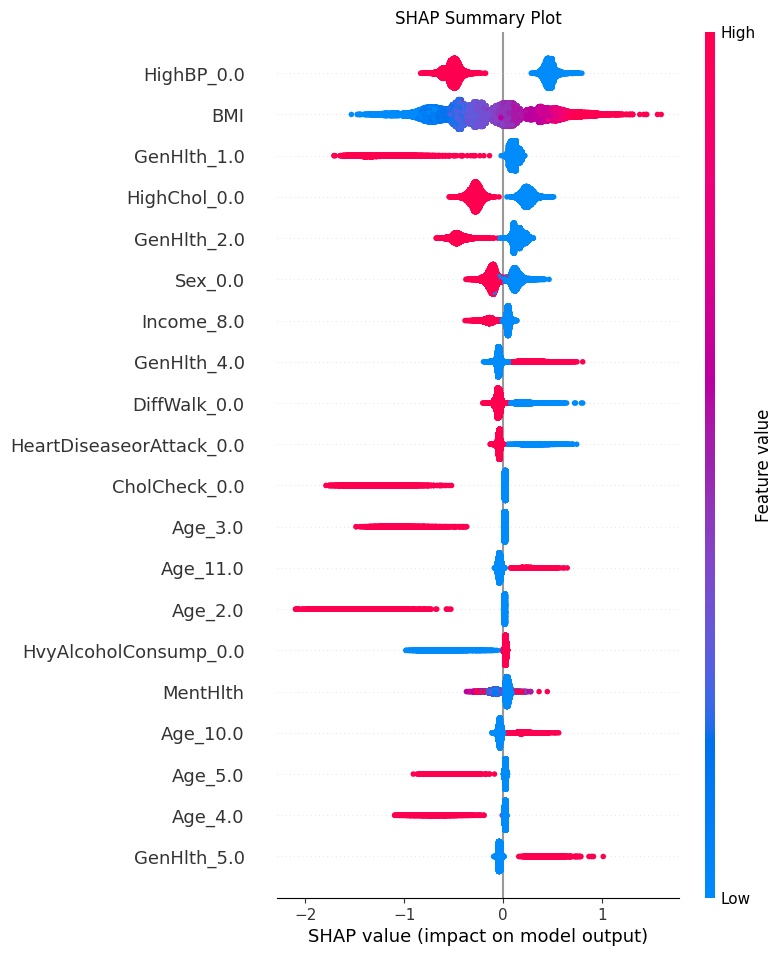

In [12]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, show=False)
plt.title("SHAP Summary Plot")
plt.show()

### Local Explanation: SHAP Force Plot

The force plot visualizes how individual features contribute to a single prediction.

For the patient below (index 0), the model predicted a low risk of diabetes (f(x) = -2.937). `BMI`, `HighBP`, and `HighChol` were the most influential in this patient's prediction, as indicated by their length in the chart.

Furthermore, this visualization allows us to determine how each feature feeds into the prediction. For example, `Income` and `GenHlth` slightly increase the risk, while `BMI`, `HighBP`, and `HighChol` significantly reduce the predicted risk.

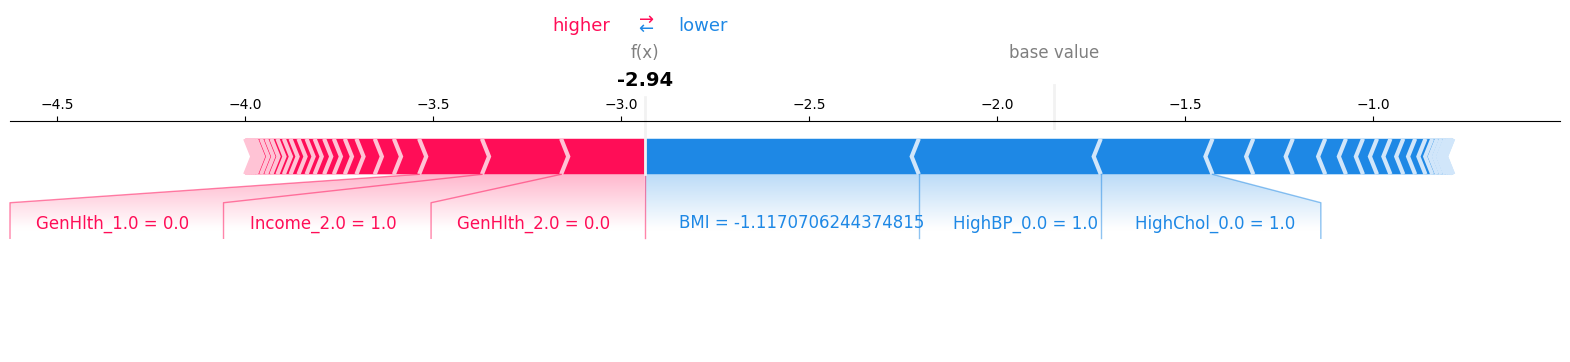

In [ ]:
idx = 0
sample = X_test.iloc[idx]

disp = shap.force_plot(
    explainer.expected_value,
    shap_values[idx],
    sample,
    matplotlib=True
)

### Local Explanation: SHAP Waterfall Plot

The waterfall plot below continues a detailed breakdown of the same patient. According to the visualization, the average prediction value of the model is -1.85. The final prediction for the patient (represent by index 0) is -2.937, driven primarily by:

- BMI: contributed -0.73 to the final value.
- HighBP: contributed -0.48 to the final value.
- HighChol: contributed -0.3 to the final value.

This visualization clearly shows how each feature shifts the prediction, making it easier to communicate model decisions in clinical settings.

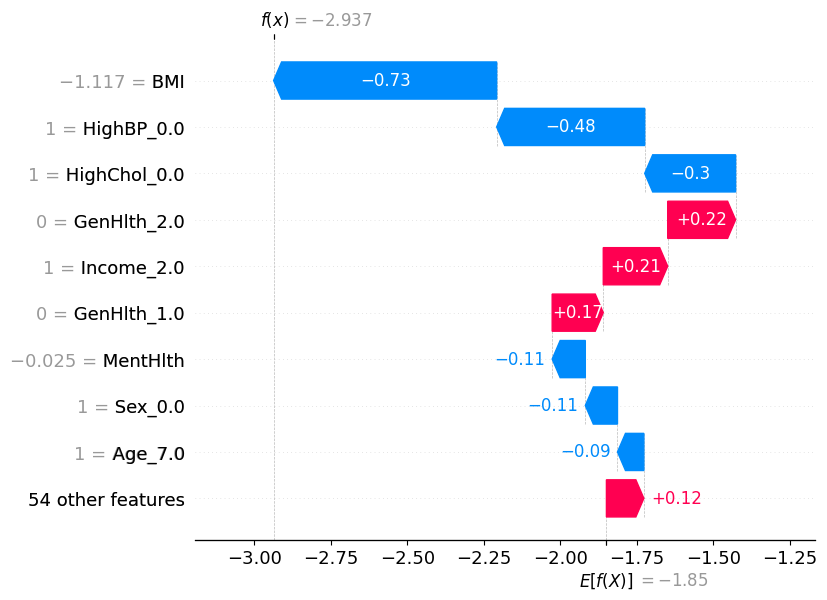

In [ ]:
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values[idx],
        base_values=explainer.expected_value,
        data=sample
    )
)

## Takeaways

This scenario illustrates how explainability techniques like SHAP can transform a high-performing but opaque model into a transparent and trustworthy diagnostic tool. These explanations not only support regulatory compliance and clinician trust, but also open the door to model refinement. To explore this idea, the original model will be compared to a simplified version trained only on the most important features identified by SHAP. This allows us to evaluate the accuracy of the SHAP visualizations, as if the final model performs similarly to the baseline, it was correct about the importance of top features.

In the cell below, the top 10 most influential features as identified by SHAP are extracted and isolated in a new dataset, which will be used to train the final model.

In [17]:
shap_values = explainer.shap_values(X_test)


shap_importance = np.abs(shap_values).mean(axis=0)
shap_summary = pd.DataFrame({
    'feature': X_test.columns,
    'importance': shap_importance
}).sort_values(by='importance', ascending=False)

top_n = 10
top_features = shap_summary['feature'].head(top_n).tolist()


X_train_simplified = X_train[top_features]
X_test_simplified = X_test[top_features]

## Final Model & Comparison

Despite using only a fraction of the original features, the final model retains nearly identical performance. This demonstrates how explainability can guide **model simplification** without significantly compromising accuracy. This is an important consideration for clinical deployment, where interpretability, auditability, and efficiency are critical.


The top features used in the final model are as follows:
`['HighBP_0.0', 'BMI', 'GenHlth_1.0', 'HighChol_0.0', 'GenHlth_2.0', 'Sex_0.0', 'Income_8.0', 'GenHlth_4.0', 'DiffWalk_0.0', 'HeartDiseaseorAttack_0.0']`

These align well with known clinical risk factors for diabetes, reinforcing the model’s alignment with domain knowledge and its potential for real-world trustworthiness. When clinicians and healthcare systems demand transparency in AI-assisted diagnosis, explainability tools like SHAP can illuminate model behavior and guide the development of simpler, more interpretable models without sacrificing clinical relevance or performance.

In [20]:
final_model = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    eval_metric='logloss',
    random_state=42
)
final_model.fit(X_train_simplified, y_train)

y_pred_simplified = final_model.predict(X_test_simplified)
y_proba_simplified = final_model.predict_proba(X_test_simplified)[:, 1]

acc_simplified = accuracy_score(y_test, y_pred_simplified)
auc_simplified = roc_auc_score(y_test, y_proba_simplified)

print(f"Baseline Model Accuracy: {acc:.3f}")
print(f"Baseline Model ROC AUC: {auc:.3f}\n")
print(f"Final Model Accuracy: {acc_simplified:.3f}")
print(f"Final Model ROC AUC: {auc_simplified:.3f}")
print("Top Features Used:", top_features)

Baseline Model Accuracy: 0.868
Baseline Model ROC AUC: 0.834

Final Model Accuracy: 0.866
Final Model ROC AUC: 0.817
Top Features Used: ['HighBP_0.0', 'BMI', 'GenHlth_1.0', 'HighChol_0.0', 'GenHlth_2.0', 'Sex_0.0', 'Income_8.0', 'GenHlth_4.0', 'DiffWalk_0.0', 'HeartDiseaseorAttack_0.0']
